# 数值积分
---

相对微分而言，积分的难度要大得多。虽然有很多可以用解析方法来计算和的积分，大部分情况下，我们需要使用数值的方法。

连续函数以及有限积分域的积分在单一维度上可以有效计算，但是对于带奇点或无限积分域的可积函数，即使是一维数值积分也很困难。二维积分和多重积分可以通过重复一维积分来进行计算，但是计算量会随着维度上升急剧增长。高维积分需要使用蒙特卡罗采样算法等技术。

除了进行数值计算外，积分还有很多其他同途：
1. [积分方程](https://zh.m.wikipedia.org/zh/积分方程)（含有未知函数的积分进行运算的方程）经常在科学和工程中使用。积分方程一般很难求解，通常可以将它们离散化，然后转换为线性方程组。
2. [积分变换](https://zh.m.wikipedia.org/zh/积分变换)，可用于不同域之间的函数和方程变换，例如傅里叶变换。

## 导入模块
---

本部分我们将主要使用SciPy的integrate模块进行数值积分。针对高精度浮点运算的需要，我们也会搭配使用SymPy和[mpmath](https://mpmath.org/)进行任意精度积分。

In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from scipy import integrate
import sympy
import mpmath

## 数值积分
---

我们将计算形式为$I(f) = \int_a^b f(x) dx$的定积分，积分的上下限分别为a和b，区间可以是有限的、半无穷的和无穷的。

积分$I(f)$可以理解为积分函数$f(x)$的曲线和x轴之间的面积。

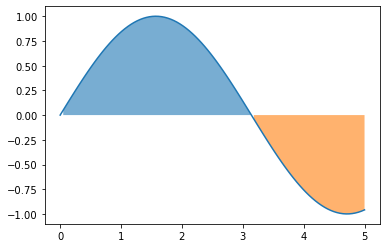

In [45]:
x = np.linspace(0, 5, 100)
plt.plot(x, np.sin(x))
plt.fill_between(x[np.sin(x) > 0], 0, np.sin(x[np.sin(x) > 0]), alpha = 0.6)
plt.fill_between(x[np.sin(x) < 0], 0, np.sin(x[np.sin(x) < 0]), alpha = 0.6)

一种计算上述形式积分$I(f)$的策略是，将积分写成积分函数值的离散和：

$$I(f) = \sum_{i=1}^{n} w_i f(x_i)+r_n$$

其中$w_i$是函数$f(x)$在点$x_i$处的权重，$r_n$是近似误差。

$I(f)$这个求和公式被称为n点求积法则，其中n的选择、点的位置、权重因子都会对计算的准确性和复杂性产生影响。

### 积分法则

积分法则可以通过在区间[a, b]上对函数$f(x)$进行插值推导而来。如果$x_i$在区间[a, b]上是均匀间隔的，那么可以使用多项式插值，得到的公式被称为[牛顿-科特斯求积公式](https://zh.m.wikipedia.org/zh-hans/牛頓－寇次公式)。

使用中间点的零阶多项式逼近$f(x)$，可以得到：
$$\int_a^b f(x) dx \approx f(\frac{a+b}{2}) \int_a^b dx = (b-a)\frac{a+b}{2}$$
这被称为中点公式。

使用一阶多项式（线性）逼近$f(x)$，可以得到：
$$\int_a^b f(x) dx \approx  \frac{b-a}{2}(f(a)+f(b))$$
这被称为梯形公式公式。

### 辛普森求积公式 Simpson's rule

使用二阶插值多项式，将会得到辛普森公式：
$$\int_a^b f(x) dx \approx  \frac{b-a}{6}(f(a)+4f(\frac{a+b}{2})+f(b))$$


我们这里使用SymPy符号化推导该公式。

In [46]:
a, b, X = sympy.symbols("a, b, x")
f = sympy.Function("f")

In [47]:
x = a, (a+b)/2, b # simpson's rule
w = [sympy.symbols("w_%d" % i) for i in range(len(x))] 

In [48]:
q_rule = sum([w[i] * f(x[i]) for i in range(len(x))])
q_rule

w_0*f(a) + w_1*f(a/2 + b/2) + w_2*f(b)

为了得到适合权重因子$w_i$的值，我们使用多项式基函数$\left\{ \phi_n(x)=x^n \right\}_{n=0}^2$对$f(x)$进行插值。

In [49]:
phi = [sympy.Lambda(X, X**n) for n in range(len(x))]
phi

[Lambda(x, 1), Lambda(_x, _x), Lambda(x, x**2)]

将求和公式中的$f(x)$替换为基函数$\phi_n(x)$，对权重因子进行解析求解：

$$ \sum_{i=1}^{2} w_i \phi_n(x_i) = \int_a^b \phi_n(x) dx$$

In [50]:
eqs = [q_rule.subs(f, phi[n]) - sympy.integrate(phi[n](X), (X, a, b)) for n in range(len(phi))]
eqs

[a - b + w_0 + w_1 + w_2,
 a**2/2 + a*w_0 - b**2/2 + b*w_2 + w_1*(a/2 + b/2),
 a**3/3 + a**2*w_0 - b**3/3 + b**2*w_2 + w_1*(a/2 + b/2)**2]

通过求解该线性方程组可以得到权重因子的解析表达式。

In [51]:
w_sol = sympy.solve(eqs, w)
w_sol

{w_0: -a/6 + b/6, w_1: -2*a/3 + 2*b/3, w_2: -a/6 + b/6}

得到辛普森求积公式的解析表达式。

In [9]:
q_rule.subs(w_sol).simplify()

-(a - b)*(f(a) + f(b) + 4*f(a/2 + b/2))/6

### 高斯求积公式 Gaussian quadrature

牛顿-科特斯求积公式的采样点在积分区间上是均匀分布的，对于非均匀分布采样，可以使用[高斯求积公式](https://zh.m.wikipedia.org/zh-hans/高斯求积)。

我们可以把函数$f(x)$写作$ f(x) = W(x)g(x)$，其中$g(x)$是近似多项式， $W(x)$是已知的权重函数，这样我们就有

$$ \int _{-1}^{1}f(x)dx=\int _{-1}^{1}W(x)g(x)dx\approx \sum _{i=1}^{n}w_{i}'g(x_{i})$$

常见的权重函数有$W(x)=(1-x^{2})^{-1/2}$（高斯切比雪夫）、$W(x)=e^{{-x^{2}}}$（高斯埃米特）等。

权重函数$W(x)=1$时，关联多项式为勒让得多项式$P_{n}(x)$，这种方法通常称为高斯勒让德求积。

## 使用SciPy进行数值积分
---

SciPy的integrate模块中的数值求积函数可以分为两类：一类将被积函数作为Python函数传入，另一类将被积函数在给定点的样本值以数组的形式传入。第一类函数使用高斯求积法（[quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)、[quadrature](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quadrature.html)、[fixed_quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.fixed_quad.html)），第二类函数使用牛顿-科斯特求积法（[trapezoid](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapezoid.html)、[simpson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simpson.html)、[romb](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.romb.html)）。

### 高斯积分

`quadrature`函数是一个使用Python实现的自适应高斯求积程序。`quadrature`函数会重复调用`fixed_quad`函数，并不断增加多项式的次数，直到满足所需的精度。`quad`函数是对Fortran库QUADPACK的封装，有更好的性能。一般情况下优先使用`quad`函数。

考虑定积分$\int _{-1}^{1}e^{-x^2}dx$

In [10]:
def f(x):
    return np.exp(-x**2)

val, err = integrate.quad(f, -1, 1)
val, err

(1.493648265624854, 1.6582826951881447e-14)

`quad`函数返回一个元组，包含积分的数值结果和绝对误差估计。可以使用参数epsabs和epsrel来设置绝对误差和相对误差的容忍度。

`quad`函数的关键词参数args可以将函数的参数值传递给被积函数。

考虑含参数定积分$\int _{-1}^{1}ae^{-(x-b)^2/c^2}dx$

In [11]:
def f(x, a, b, c):
    return a * np.exp(-((x-b)/c)**2)

val, err = integrate.quad(f, -1, 1, args=(1, 2, 3))
val, err

(1.2763068351022229, 1.4169852348169507e-14)

当被积分函数的变量不是第一个参数是，可以使用lambda函数来调整参数的顺序。

例如我们使用`scipy.special`模块的jv函数计算0阶贝塞尔函数的积分，jv函数的第一个参数是贝塞尔函数的阶数，第二个参数是变量x。

In [12]:
from scipy.special import jv

val, err = integrate.quad(lambda x: jv(0, x), 0, 5)
val, err

(0.7153119177847678, 2.47260738289741e-14)

#### 无穷积分

`quad`函数支持无穷积分。浮点数中的无穷表达式可以使用`np.inf`获得。

考虑使用`quad`函数计算$\int _{-\infty}^{\infty}e^{-x^2}dx$

In [13]:
f = lambda x: np.exp(-x**2)
val, err = integrate.quad(f, -np.inf, np.inf)
val, err

(1.7724538509055159, 1.4202636780944923e-08)

#### 发散函数积分

通过一些额外信息，`quad`函数也可以处理带可积奇点的函数。

考虑积分$\int _{-1}^{1} \frac{1}{\sqrt{|x|}}dx$，被积函数在$x=0$处是发散的。

(0.0, 25.0)

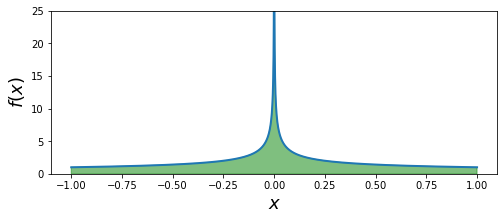

In [14]:
f = lambda x: 1/np.sqrt(abs(x))

fig, ax = plt.subplots(figsize=(8, 3))

a, b = -1, 1
x = np.linspace(a, b, 10000)
ax.plot(x, f(x), lw=2)
ax.fill_between(x, f(x), color='green', alpha=0.5)
ax.set_xlabel("$x$", fontsize=18)
ax.set_ylabel("$f(x)$", fontsize=18)
ax.set_ylim(0, 25)

In [15]:
integrate.quad(f, a, b) # 直接使用quad函数求积分，可能会失败

/tmp/ipykernel_110080/3901929116.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  f = lambda x: 1/np.sqrt(abs(x))


(inf, inf)

In [16]:
integrate.quad(f, a, b, points=[0])

(3.9999999999999813, 5.684341886080802e-14)

`quad`函数的points参数可以设置需要绕过的点，从而正确地计算积分。

### 列表积分

`quad`函数只适合于被积函数可以被Python函数表示的积分。如果被积函数来自实验或者观察数据，其可能只可以在某些预先确定的点求值。这种情况下，可以使用牛顿-科特斯求积法，如之前介绍的中间点公式、梯形公式或辛普森公式。

在SciPy的integrate模块中，`trapezoid`和`simpson`函数分别实现了复化梯形公式和辛普森公式。这些函数的第一个参数是数组y，第二个参数是采样点数组x或者采样点间隔dx。

考虑积分$\int _{0}^{2} \sqrt{x} dx$，积分区间为[0, 2]，采样点数目25。

Text(0, 0.5, '$f(x)$')

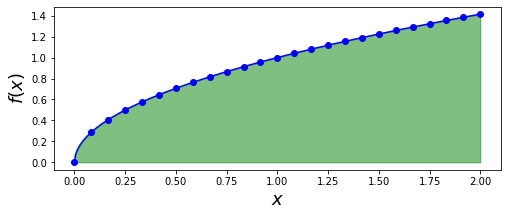

In [17]:
f = lambda x: np.sqrt(x)
a, b = 0, 2
x = np.linspace(a, b, 25)
y = f(x)

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, y, 'bo')
xx = np.linspace(a, b, 500)
ax.plot(xx, f(xx), 'b-')
ax.fill_between(xx, f(xx), color='green', alpha=0.5)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$f(x)$", fontsize=18)

通过解析积分可以得到积分的精确值。

In [18]:
val_exact = 2.0/3.0 * (b-a)**(3.0/2.0)
val_exact

1.8856180831641267

要计算这个积分，将数组y和x传递给`trapezoid`函数或`simpson`函数。

In [19]:
val_trapz = integrate.trapz(y, x)
val_trapz - val_exact

-4.796367113276245e-03

In [20]:
val_simps = integrate.simps(y, x)
val_simps - val_exact

-0.001952980715411723

`trapezoid`函数和`simpson`函数无法提供对误差的估计。提供准确度的方法是增加样品点的数量或者使用更高阶的方法。

integrate模块中的`romb`函数实现了[Romberg方法](https://en.wikipedia.org/wiki/Romberg%27s_method)。这种方法使用均匀间隔的采样点（数目为$2^n+1$），同时使用Richardson外推算法来加速梯形法的收敛。

In [21]:
x = np.linspace(a, b, 1 + 2**6)
y = f(x)
val_romb = integrate.romb(y, dx=(x[1]-x[0]))
val_romb - val_exact

-0.00037879842291310695

一般情况下，推荐使用`simpson`函数。

## 多重积分
---

多重积分，例如二重积分$\int _{a}^{b}\int _{c}^{d}f(x, y)dxdy$和三重积分$\int _{a}^{b}\int _{c}^{d}\int _{e}^{f}f(x, y, z)dxdydz$，可以使用SciPy的integrate模块的`dblquad`和`tplquad`函数。n个变量的积分也可以使用`nquad`函数来计算。这些函数都是对单变量求积函数`quad`的封装，沿着被积函数每个维度重复调用quad函数。

考虑二重积分$\int _{0}^{1}\int _{0}^{1}e^{-x^2-y^2}dxdy$

Text(0, 0.5, '$y$')

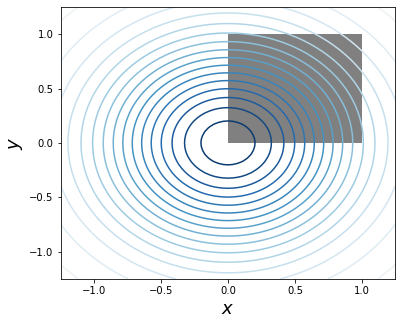

In [22]:
def f(x, y):
    return np.exp(-x**2-y**2)

fig, ax = plt.subplots(figsize=(6, 5))

x = y = np.linspace(-1.25, 1.25, 75)
X, Y = np.meshgrid(x, y)

c = ax.contour(X, Y, f(X, Y), 15, cmap=mpl.cm.RdBu, vmin=-1, vmax=1)

bound_rect = plt.Rectangle((0, 0), 1, 1,
                           facecolor="grey")
ax.add_patch(bound_rect)

ax.axis('tight')
ax.set_xlabel('$x$', fontsize=18)
ax.set_ylabel('$y$', fontsize=18)

本例中，x和y的积分限都是固定的。`dblquad`函数要求y变量的积分限用变量为x的函数表示，因此我们需要定义两个函数$g(x)$和$h(x)$，二者返回常量。

In [23]:
a, b = 0, 1

g = lambda x: 0
h = lambda x: 1

val, err = integrate.dblquad(f, a, b, g, h)  # 参数g和h为函数
val, err

(0.5577462853510337, 8.291374381535408e-15)

对于形如$\int _{0}^{1}\int _{0}^{1}\int _{0}^{1}e^{-x^2-y^2-z^2}dxdydz$的三重积分，可以使用`nquad`函数计算。除了继续使用$g(x)$和$h(x)$表示y轴的积分限之外，我们需要额外提供两个函数$q(x, y)$和$r(x, y)$表示z轴的积分限。注意这里使用了x和y两个坐标。

In [24]:
def f(x, y, z):
    return np.exp(-x**2-y**2-z**2)

val, err = integrate.tplquad(f, 0, 1, lambda x : 0, lambda x : 1, lambda x, y : 0, lambda x, y : 1)
val, err

(0.4165383858866382, 8.291335287314424e-15)

对于任意维度数目的积分，可以使用`nquad`函数。它的第二个参数是用于指定积分限的列表，列表里面包含每个积分变量的积分限元组，或者包含能够返回积分限的函数。

In [25]:
integrate.nquad(f, [(0, 1), (0, 1), (0, 1)])  # 元素相同的列表可以使用 [(0, 1)] * 3 生成

(0.4165383858866382, 8.291335287314424e-15)

### 维数灾难

在数值积分中，多重积分的计算复杂度和维数成指数关系。

In [26]:
def f(*args):
    return  np.exp(-np.sum(np.array(args)**2))

for dim in range(1, 5):
    print(dim)
    %time integrate.nquad(f, [(0,1)] * dim)

1
CPU times: user 363 µs, sys: 0 ns, total: 363 µs
Wall time: 370 µs
2
CPU times: user 3.94 ms, sys: 0 ns, total: 3.94 ms
Wall time: 4.02 ms
3
CPU times: user 75.6 ms, sys: 939 µs, total: 76.5 ms
Wall time: 75.9 ms
4
CPU times: user 1.61 s, sys: 0 ns, total: 1.61 s
Wall time: 1.62 s


随着维数增加，高维积分的直接求积方法变得不切实际。如果对计算精度要求不是非常高，可以使用蒙特卡罗积分。蒙特卡罗积分在维度上的扩展性非常好，对于高维积分是一种有效的工具。

## 符号积分和任意精度积分

在符号计算的章节，我们已经演示了使用SymPy的sympy.integrate函数来计算符号函数的有限积分和无限积分。

例如，计算积分$\int_{-1}^{1} 2 \sqrt{1-x^2} dx$

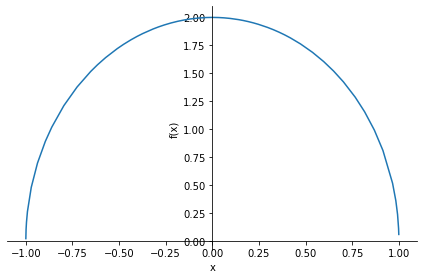

In [27]:
x = sympy.symbols("x")
f = 2 * sympy.sqrt(1-x**2)
a, b = -1, 1
sympy.plot(f, (x, -2, 2))

In [28]:
val_sym = sympy.integrate(f, (x, a, b))
val_sym

pi

存在精确解析解的问题是一种特例。数值方法的精度受算法和浮点精度制约。mpmath库为任意精度计算提供了数值方法。为了按照给定的精度计算积分，可以使用`mpmath.quad`函数。为了设置精度，我们把变量mpmath.mp.dps设置为所需精度的小数位数。

In [29]:
mpmath.mp.dps = 75  # 75位小数的精度

被积分的Python函数可以使用mpmath库中的数学函数。可以使用`sympy.lambdify`从一个SymPy表达式中创建这样的函数。

In [30]:
f_mpmath = sympy.lambdify(x, f, 'mpmath')
val = mpmath.quad(f_mpmath, (a, b))
val  # 返回的对象类型是高精度浮点数

mpf('3.14159265358979323846264338327950288419716939937510582097494459230781640628613')

In [31]:
sympy.sympify(val)

3.14159265358979323846264338327950288419716939937510582097494459230781640629

我们可以将这个结果与解析结果进行对比。

In [32]:
sympy.N(val_sym, mpmath.mp.dps+1) - val

6.908934844075555700309081490240319656892800291549025108018962776134873442530e-77

SciPy的integrate模块中的quad函数无法达到这样的精度，因为受浮点数精度的限制。

### 多重积分

mpmath库中的`quad`函数也可以用于计算多重积分。计算这样的积分，只需要把拥有多个变量参数的被积函数传给`quad`函数，并未每个积分变量传入积分限的元组。

计算下面的双重积分 $\int_{0}^{1} \int_{0}^{1} \cos(x) \cos(y) e^{-x^2-y^2} dx$

In [33]:
def f2(x, y):
    return np.cos(x)*np.cos(y)*np.exp(-x**2-y**2)

integrate.dblquad(f2, 0, 1, lambda x : 0, lambda x : 1)

(0.4305647943060992, 7.28494733311039e-15)

In [34]:
x, y, z = sympy.symbols("x, y, z")
f2 = sympy.cos(x)*sympy.cos(y)*sympy.exp(-x**2-y**2)

f2_mpmath = sympy.lambdify((x, y), f2, 'mpmath')

mpmath.mp.dps = 30  # 指定计算精度
res = mpmath.quad(f2_mpmath, (0, 1), (0, 1))
res

mpf('0.430564794306099099242308990195783')

由于高精度浮点运算是在CPU上模拟实现的，缺点是非常慢。

### 曲线积分

SymPy可以使用line_integral函数来计算形如 $\int_{C} f(x, y) ds$的曲线积分，其中C是x-y平面上的曲线。该函数的第一个参数是SymPy表示的被积函数，第二个参数是一个sympy.Curve实例，第三个参数是积分变量的列表。

例如，创建Curve实例来表示单位圆的路径。

In [35]:
t, x, y = sympy.symbols("t, x, y")
C = sympy.Curve([sympy.cos(t), sympy.sin(t)], (t, 0, 2 * sympy.pi))

积分路径指定之后，我们对被积函数$f(x, y)=1$进行积分，积分结果就是圆的周长。

In [36]:
sympy.line_integrate(1, C, [x, y])

2*pi

## 积分变换
---

积分变换是将一个函数作为输入，然后输出另有一个函数的过程。这里我们介绍使用SymPy支持的两种积分变换，[拉普拉斯变换](https://zh.wikipedia.org/wiki/拉普拉斯变换)和[傅里叶变换](https://zh.wikipedia.org/wiki/傅里叶变换)。这两种变换有很多应用，例如可以使用拉普拉斯变换将微分方程转换为代数方程，或者使用傅里叶变换将时域问题转换为频域问题。

一般来说，函数$f(t)$的积分变换可以写为：

$$T_f(u) = \int_{t_1}^{t_2} K(t, u) f(t) dt$$

其中$T_f(u)$是变换后的函数，$K(t, u)$是变换的核函数。

积分变换的逆变换是：

$$f(t) = \int_{u_1}^{u_2} K^{-1}(t, u) T_f(u) du$$

其中$K^{-1}(t, u)$是核函数的逆变换。

拉普拉斯变换
$$F(s)=\int _{0}^{\infty }f(t)e^{-st}\,\mathrm {d} t $$
及其逆变换
$$f(t)={\mathcal {L}}^{-1}\{F\}(t)={\frac {1}{2\pi i}}\lim _{T\to \infty }\int _{\gamma -iT}^{\gamma +iT}e^{st}F(s)\,\mathrm {d} s$$
以及傅里叶变换
$$\hat{f}(\xi) = \int_{-\infty}^\infty f(x)\ e^{- 2\pi i x \xi}\,dx$$
及其逆变换
$$ f(x) = \int_{-\infty}^\infty \hat f(\xi)\ e^{2 \pi i \xi x}\,d\xi $$

在SymPy中，拉普拉斯变换和傅里叶变换对应的函数为`sympy.laplace_transform`和`sympy.fourier_transform`，其逆变换为`sympy.inverse_laplace_transform`和`sympy.inverse_fourier_transform`。

**示例** 计算函数$f(t) = \sin(at)$的拉普拉斯变换

In [37]:
s = sympy.symbols("s")
a, t = sympy.symbols("a, t", positive=True)
f = sympy.sin(a*t)

In [38]:
sympy.laplace_transform(f, t, s)

(a/(a**2 + s**2), -oo, re(s) > 0)

默认情况下，`laplace_transform`函数返回一个元组，包含转换结果和变换的收敛条件。如果只需要转换结果，可以使用参数noconds=True去除返回中的条件。

In [39]:
F = sympy.laplace_transform(f, t, s, noconds=True)
F

a/(a**2 + s**2)

逆变换将得到原始函数：

In [40]:
sympy.inverse_laplace_transform(F, s, t, noconds=True)

sin(a*t)

我们将在微分方程章节中拉普拉斯变换的应用。

**示例** 计算函数$f(t) = e^{-at^2}$的傅里叶变换

In [41]:
w = sympy.symbols("omega")
a, t = sympy.symbols("a, t", positive=True)
f = sympy.exp(-a*t**2)

In [42]:
F = sympy.fourier_transform(f, t, w)
F

sqrt(pi)*exp(-pi**2*omega**2/a)/sqrt(a)

In [43]:
sympy.inverse_fourier_transform(F, w, t)

exp(-a*t**2)

我们在信号处理章节中演示了傅里叶变换在降噪中的应用。